# 必要なライブラリの準備

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Subset

from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, roc_auc_score, confusion_matrix
from time import time
from copy import deepcopy

import numpy as np
import pandas as pd

import pickle
import json

from winsound import Beep

import matplotlib.pyplot as plt
from matplotlib import ticker
%matplotlib inline

# ハイパーパラメータ・活性化関数・最適化アルゴリズムの定義

In [2]:
hyperparam_dict = {

    'API_type' : 307,
    'hidden1_dim' : 70,
    'n_classes' : 1,

    'bias1' : True,
    'bias2' : True,

    'dropout1_rate' : 0.5,

    'epoch' : 1000,
    'loss_func' : nn.BCEWithLogitsLoss(),

    'optimizer' : {
        'algorithm' : optim.Adam,
        'param' : {
            'lr' : 1e-3,
            'weight_decay' : 0,
        }
    },

    'batch_size' : 128,
    'n_splits' : 10,

    'fold_index' : 0,
    'fold_random_state' : 0,
    'weight_random_state' : 0,

    'device' : torch.device('cuda'),

}

# データセットの作成

In [3]:
df = pd.read_csv('./dynamic_api_call_sequence_per_malware_100_0_306.csv')
df

,hash,t_0,t_1,t_2,t_3,t_4,t_5,t_6,t_7,t_8,...,t_91,t_92,t_93,t_94,t_95,t_96,t_97,t_98,t_99,malware
0,071e8c3f8922e186e57548cd4c703a5d,112,274,158,215,274,158,215,298,76,...,71,297,135,171,215,35,208,56,71,1
1,33f8e6d08a6aae939f25a8e0d63dd523,82,208,187,208,172,117,172,117,172,...,81,240,117,71,297,135,171,215,35,1
2,b68abd064e975e1c6d5f25e748663076,16,110,240,117,240,117,240,117,240,...,65,112,123,65,112,123,65,113,112,1
3,72049be7bd30ea61297ea624ae198067,82,208,187,208,172,117,172,117,172,...,208,302,208,302,187,208,302,228,302,1
4,c9b3700a77facf29172f32df6bc77f48,82,240,117,240,117,240,117,240,117,...,209,260,40,209,260,141,260,141,260,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43871,e3d6d58faa040f0f9742c9d0eaf58be4,82,240,117,240,117,240,117,240,117,...,141,260,141,260,141,260,141,260,141,1
43872,9b917bab7f32188ae40c744f2be9aaf8,82,240,117,240,117,240,117,240,117,...,159,224,82,159,224,82,159,224,82,1
43873,35a18ee05f75f04912018d9f462cb990,82,240,117,240,117,240,117,240,117,...,260,141,260,141,260,141,260,141,260,1
43874,654139d715abcf7ecdddbef5a84f224b,82,240,117,240,117,240,117,240,117,...,141,260,141,260,141,260,141,260,141,1


In [4]:
X = df.drop(['hash', 'malware'], axis = 1).values.astype(int)
y = df['malware'].values.astype(float)
del df
print(X.shape)
print(y.shape)
dataset = list(zip(X, y))

(43876, 100)
(43876,)


In [5]:
fold = KFold(n_splits = hyperparam_dict['n_splits'],
             shuffle = True,
             random_state = hyperparam_dict['fold_random_state'])

# モデルの定義

In [6]:
class RNN_network(nn.Module):
    
    def __init__(self, input_dim, hidden1_dim, n_classes, dropout1_rate, bias1=True, bias2=True):
        
        super(RNN_network, self).__init__()
        
        self.input_dim = input_dim
        self.hidden1_dim = hidden1_dim
        self.dropout1_rate = dropout1_rate
        
        self.rnn1 = nn.RNN(self.input_dim, self.hidden1_dim, batch_first = True, bias = bias1)
        self.dropout1 = nn.Dropout(p = self.dropout1_rate)
        self.fc = nn.Linear(self.hidden1_dim, n_classes, bias = bias2)
        
    def forward(self, X):
        
        X = F.one_hot(X, num_classes = self.input_dim).float().cuda()
        
        # Hidden layer shape: (num_layers, batch_size, hidden_dim)
        hidden_0 = torch.zeros(1, X.size(0), self.hidden1_dim).float().cuda()
        
        # Input/Output shape: (batch_size, seq_len, input_dim)
        _, self.hidden1 = self.rnn1(X, hidden_0)
                
        H = self.hidden1[0].squeeze()
        H = self.dropout1(H)
        H = self.fc(H)
                
        return H.squeeze()

# 評価値の定義

In [7]:
def evaluate(loader, model, metric_dict):

    sum_loss = 0.0
    all_dataset = len(loader.dataset)
    all_output = torch.tensor([]).to(hyperparam_dict['device'])
    all_label = torch.tensor([]).to(hyperparam_dict['device'])

    for batch_data, batch_label in loader:
        batch_data, batch_label = batch_data.long().to(hyperparam_dict['device']), batch_label.to(hyperparam_dict['device'])
        batch_output = model(batch_data)
        batch_loss = loss_func(batch_output, batch_label)
        optimizer.zero_grad()

        sum_loss += batch_loss.detach().item() * batch_output.shape[0]
        all_output = torch.cat((all_output, batch_output))
        all_label = torch.cat((all_label, batch_label))

    sigmoid = nn.Sigmoid()
    all_pred, all_score, all_label = (all_output >= 0).cpu(), sigmoid(all_output).cpu(), all_label.cpu()
    tn, fp, fn, tp = confusion_matrix(all_label, all_pred).flatten()

    metric_dict['Loss'].append(sum_loss / all_dataset)
    metric_dict['Accuracy'].append(accuracy_score(all_label, all_pred))
    metric_dict['Precision'].append(precision_score(all_label, all_pred))
    metric_dict['Recall'].append(recall_score(all_label, all_pred))
    metric_dict['F1-Score'].append(f1_score(all_label, all_pred))
    metric_dict['ROC-Curve'].append(roc_curve(all_label, all_score))
    metric_dict['AUC'].append(roc_auc_score(all_label, all_pred))
    metric_dict['TP'].append(tp)
    metric_dict['FP'].append(fp)
    metric_dict['TN'].append(tn)
    metric_dict['FN'].append(fn)

# 学習と評価

In [8]:
metric_dict = {
    'Loss' : [],
    'Accuracy' : [],
    'Precision' : [],
    'Recall' : [],
    'F1-Score' : [],
    'ROC-Curve' : [],
    'AUC': [],
    'TP' : [],
    'TN' : [],
    'FP' : [],
    'FN' : [],
}

eval_dict = {
    'Train' : deepcopy(metric_dict),
    'Test' : deepcopy(metric_dict),
    'Time' : {
        'Train_Time' : [],
        'Eval_Time' : [],
    },
}

loss_func = hyperparam_dict['loss_func']

train_idx, test_idx = list(fold.split(dataset))[hyperparam_dict['fold_index']]

print(f'Fold {hyperparam_dict["fold_index"]}')

torch.manual_seed(hyperparam_dict['weight_random_state'])

model = RNN_network(
    input_dim = hyperparam_dict['API_type'],
    hidden1_dim = hyperparam_dict['hidden1_dim'],
    n_classes = hyperparam_dict['n_classes'],
    dropout1_rate = hyperparam_dict['dropout1_rate'],
    bias1 = hyperparam_dict['bias1'],
    bias2 = hyperparam_dict['bias2'],
    ).to(hyperparam_dict['device'])

optimizer = hyperparam_dict['optimizer']['algorithm'](
    params = model.parameters(),
    lr = hyperparam_dict['optimizer']['param']['lr'],
    weight_decay = hyperparam_dict['optimizer']['param']['weight_decay']
    )

temp_optim = {key : optimizer.param_groups[0][key] for key in optimizer.param_groups[0] if key != 'params'}
temp_optim['betas'] = list(temp_optim['betas'])
hyperparam_dict['optimizer']['param'] = temp_optim

for i, param in enumerate(model.parameters()):
    print(f'\nparam {i}')
    print(param.shape)
    print(param)
print(f'\nParameters: {np.sum([param.numel() for param in model.parameters()])}\n')

train_loader = DataLoader(
    Subset(dataset, train_idx),
    shuffle = True,
    batch_size = hyperparam_dict['batch_size'],
    )

test_loader = DataLoader(
    Subset(dataset, test_idx),
    shuffle = False,
    batch_size = hyperparam_dict['batch_size'],
    )

for epoch in range(hyperparam_dict['epoch']):

    # Training
    start_train_time = time()
    model.train()
    for batch_data, batch_label in train_loader:
        batch_data, batch_label = batch_data.long().to(hyperparam_dict['device']), batch_label.to(hyperparam_dict['device'])
        output = model(batch_data)
        loss = loss_func(output, batch_label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()       
    eval_dict['Time']['Train_Time'].append(time() - start_train_time)

    # Evaluation
    start_eval_time = time()
    model.eval()
    with torch.no_grad():

        # Trainset
        evaluate(
            loader = train_loader,
            model = model,
            metric_dict = eval_dict['Train'],
            )

        # Testset
        evaluate(
            loader = test_loader,
            model = model,
            metric_dict = eval_dict['Test'],
        )
        
    eval_dict['Time']['Eval_Time'].append(time() - start_eval_time)

    if (epoch + 1) % 100 == 0:
        print(f'Epoch {epoch + 1}')
        for key, value in eval_dict.items():
            print(f'\n\t{key}')
            for metric in value:
                if metric != 'ROC-Curve':
                    print(f'\t\t{metric} : {value[metric][-1]}')
        print()

torch.save(model.state_dict(), f'param{hyperparam_dict["fold_index"]}.pth')

Fold 0

param 0
torch.Size([70, 307])
Parameter containing:
tensor([[-0.0009,  0.0641, -0.0984,  ...,  0.0235, -0.0887,  0.0199],
        [ 0.0509,  0.0473, -0.0150,  ..., -0.0931,  0.0996, -0.0527],
        [ 0.0424,  0.1040,  0.0603,  ...,  0.0527,  0.0163,  0.0583],
        ...,
        [ 0.0338, -0.0995,  0.0920,  ..., -0.0866,  0.0775,  0.0699],
        [-0.0234,  0.0756, -0.0271,  ...,  0.1105,  0.1061,  0.0636],
        [ 0.1083, -0.1187, -0.0819,  ..., -0.0609,  0.0937, -0.0805]],
       device='cuda:0', requires_grad=True)

param 1
torch.Size([70, 70])
Parameter containing:
tensor([[ 0.1129, -0.0514, -0.0657,  ..., -0.1144,  0.0238,  0.0547],
        [-0.0711,  0.0080, -0.1041,  ..., -0.0096,  0.0511, -0.0306],
        [-0.0498, -0.1017,  0.0328,  ...,  0.0704, -0.0856, -0.0762],
        ...,
        [-0.0868,  0.0145, -0.0251,  ..., -0.0976,  0.0574,  0.1126],
        [ 0.1020,  0.0956, -0.0018,  ...,  0.0959,  0.0089, -0.0094],
        [ 0.0284,  0.1117,  0.1011,  ...,  0.06

# 評価値の出力

In [9]:
def plot(epoch, data1, data2, ylabel, ylim_bottom=0, ylim_top=1, save=True, legend1='train', legend2='test'):

    fig = plt.figure()
    ax = fig.add_subplot(1,1,1, title=ylabel, xlabel='epoch', xlim=(0, epoch), ylabel=ylabel, ylim=(ylim_bottom, ylim_top))

    ax.plot(range(epoch), np.array(data1), marker='None')
    
    if data2:
        ax.plot(range(epoch), np.array(data2), marker='None', c='#ff00ff')
        ax.legend([f'{legend1}', f'{legend2}'])
    else:
        ax.legend(f'{ylabel}')

    ax.grid()
    # ax.xaxis.set_major_locator(ticker.MultipleLocator(1)) 

    if save:
        plt.savefig(f'{ylabel}.png')

    plt.show()

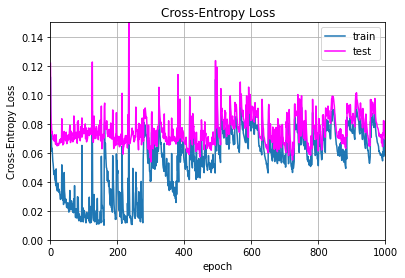

In [10]:
plot(hyperparam_dict['epoch'], eval_dict['Train']['Loss'], eval_dict['Test']['Loss'], 'Cross-Entropy Loss', ylim_top=0.15)

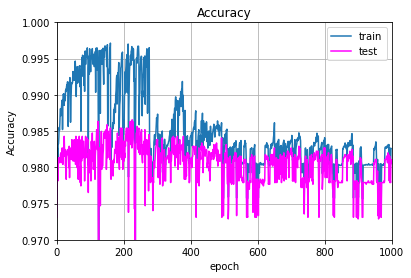

In [11]:
plot(hyperparam_dict['epoch'], eval_dict['Train']['Accuracy'], eval_dict['Test']['Accuracy'], 'Accuracy', ylim_bottom=0.97)

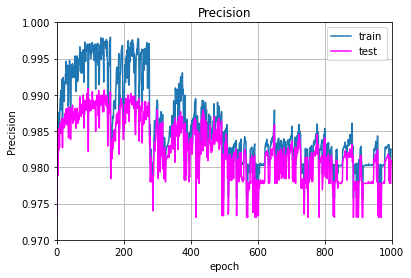

In [12]:
plot(hyperparam_dict['epoch'], eval_dict['Train']['Precision'], eval_dict['Test']['Precision'], 'Precision', ylim_bottom=0.97)

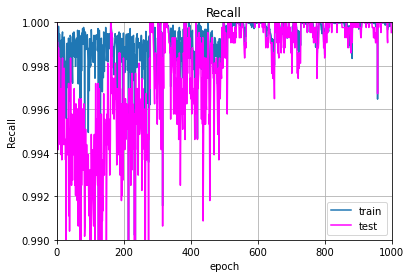

In [13]:
plot(hyperparam_dict['epoch'], eval_dict['Train']['Recall'], eval_dict['Test']['Recall'], 'Recall', ylim_bottom=0.99)

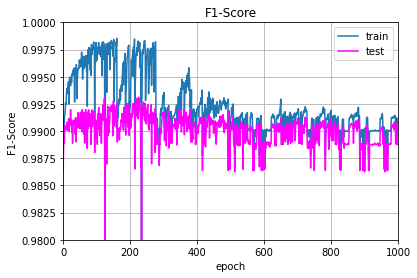

In [14]:
plot(hyperparam_dict['epoch'], eval_dict['Train']['F1-Score'], eval_dict['Test']['F1-Score'], 'F1-Score', ylim_bottom=0.98)

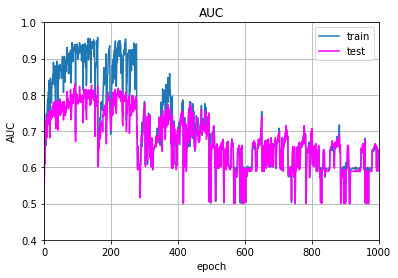

In [15]:
plot(hyperparam_dict['epoch'], eval_dict['Train']['AUC'], eval_dict['Test']['AUC'], 'AUC', ylim_bottom=0.4)

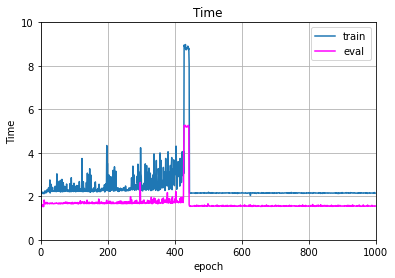

In [16]:
plot(hyperparam_dict['epoch'], eval_dict['Time']['Train_Time'], eval_dict['Time']['Eval_Time'], 'Time', ylim_top=10, legend2='eval')

In [17]:
def find_max(eval_dict):
    for key, value in eval_dict.items():
        if key != 'Time':
            print(key)
            for metric in value:
                if metric not in {'Loss', 'ROC-Curve', 'TP', 'FP', 'TN', 'FN'}:
                    print(metric)
                    print(max(enumerate(np.array(value[metric])), key = lambda x : x[1]))
            print()

find_max(eval_dict)

Train
Accuracy
(160, 0.9971383711507293)
Precision
(160, 0.9979518821943378)
Recall
(0, 1.0)
F1-Score
(160, 0.9985343519371198)
AUC
(160, 0.9584557333158819)

Test
Accuracy
(225, 0.9865542388331814)
Precision
(93, 0.9908814589665653)
Recall
(0, 1.0)
F1-Score
(225, 0.9931227415782726)
AUC
(93, 0.8309986901123327)



In [18]:
def output(metric, key = 'Test' ,digit = 4):
    for i, x in enumerate(np.array(eval_dict[key][metric])):
        print(f'{i} : {round(x, digit)}')

output('F1-Score')

0 : 0.9864
1 : 0.9884
2 : 0.9904
3 : 0.9889
4 : 0.9897
5 : 0.9905
6 : 0.9902
7 : 0.9901
8 : 0.9905
9 : 0.9904
10 : 0.9902
11 : 0.9907
12 : 0.9908
13 : 0.9901
14 : 0.9903
15 : 0.9902
16 : 0.9912
17 : 0.9905
18 : 0.99
19 : 0.9906
20 : 0.9907
21 : 0.9909
22 : 0.992
23 : 0.991
24 : 0.9906
25 : 0.991
26 : 0.9899
27 : 0.9907
28 : 0.9889
29 : 0.9904
30 : 0.9909
31 : 0.9907
32 : 0.991
33 : 0.9907
34 : 0.9909
35 : 0.9906
36 : 0.9897
37 : 0.9913
38 : 0.989
39 : 0.9909
40 : 0.9908
41 : 0.991
42 : 0.9912
43 : 0.9903
44 : 0.9903
45 : 0.9917
46 : 0.9908
47 : 0.9907
48 : 0.9907
49 : 0.9902
50 : 0.9907
51 : 0.9916
52 : 0.9917
53 : 0.9909
54 : 0.9902
55 : 0.9911
56 : 0.99
57 : 0.992
58 : 0.9902
59 : 0.9911
60 : 0.9915
61 : 0.9897
62 : 0.9917
63 : 0.9906
64 : 0.9889
65 : 0.9909
66 : 0.9906
67 : 0.992
68 : 0.9905
69 : 0.9905
70 : 0.9887
71 : 0.9898
72 : 0.9884
73 : 0.9917
74 : 0.9902
75 : 0.991
76 : 0.992
77 : 0.9904
78 : 0.991
79 : 0.9916
80 : 0.9916
81 : 0.9908
82 : 0.9903
83 : 0.9888
84 : 0.9899
85 : 

0.8095998888580161


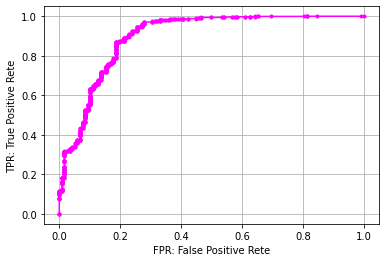

In [19]:
def plot_ROC_Curve(epoch, key = 'Test'):

    fpr, tpr, _ = eval_dict['Test']['ROC-Curve'][epoch]
    print(eval_dict['Test']['AUC'][epoch])
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    ax.plot(fpr, tpr, marker='.',c='#ff00ff')
    ax.set_xlabel('FPR: False Positive Rete')
    ax.set_ylabel('TPR: True Positive Rete')
    # ax.set_aspect('equal')
    ax.grid()

plot_ROC_Curve(232)

# ハイパーパラメータ・評価値の保存

In [20]:
hyperparam_dict['loss_func'] = str(hyperparam_dict['loss_func'])
hyperparam_dict['device'] = str(hyperparam_dict['device'])
hyperparam_dict['optimizer']['algorithm'] = str(hyperparam_dict['optimizer']['algorithm'])

json.dump(hyperparam_dict, open('hyperparameter.json', 'w'), indent=4)
pickle.dump(eval_dict, open('evaluation.pkl', 'wb'))

# 学習・保存の終了時にビープ音で通知

In [21]:
Beep(1100, 1000)